# Overview

Let's fix the initial high loss of training MLP in the notebook [MLP as a basic script](https://www.kaggle.com/code/aisuko/mlp-as-a-basic-script/notebook).

# Fixing the high initial loss issue

Below is the training loss history of our MLP.

```
      0/ 200000: 27.8817
  10000/ 200000: 2.9571
  20000/ 200000: 2.5722
```

You can see we have a extreme loss in our first training loop. That is the way to high. High loss at the beginning of training will cause accuracy issueof the neural net.

## What the loss we are expected?

**We expected the probability distribution that comes out initialy is a uniform distribution.** And it relates to the value of logits which means we want the logits of our neural net to be more closer to zero.

See a 4-dimensional example of the issue. Our logits does't contains any extreme values. So, it doesn't actually matter if the label is 2 or 3 becuase it's a uniform distrubtion and we are recording the exact same loss in this case.

In [1]:
import torch

# We like the probability for any character would be roughly 1 over 27, 1/27.0

# we wrap it in a tensor
-torch.tensor(1/27.0).log()

tensor(3.2958)

In [2]:
logits=torch.tensor([0.0,0.0,0.0,0.0])
probs=torch.softmax(logits, dim=0)
loss=-probs[2].log() # label here
probs, loss

(tensor([0.2500, 0.2500, 0.2500, 0.2500]), tensor(1.3863))

## Example the loss without uniform distribution

It's for us to guess the correct loss without uniform distrubution. And if the logits are coming out even more extreme you might get extremly insane losses like infinity even at initialization. We want the logits to be roughly zero when the network initialized.

In [3]:
logits=torch.randn(4)*100 # let's make the logits with extreme values
probs=torch.softmax(logits, dim=0)
loss=-probs[2].log()
logits, probs, loss

(tensor([-46.5240,  49.6721, -57.1356, -52.3020]),
 tensor([1.6689e-42, 1.0000e+00, 0.0000e+00, 5.6052e-45]),
 tensor(inf))

## How to fix the high loss of the beginning of training?

Scale down the output layer's weight by 0.1 or 0.01 and set bias of that layer to zero.

# Pre-process step

In [4]:
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
from torch.utils.tensorboard import SummaryWriter


# read in all the words
with open('/kaggle/input/character-lm-without-framework/names.txt', 'r', encoding='utf-8') as f:
    words=f.read()

words=words.splitlines()

# build the vocabulary of characters and 
chars=sorted(list(set(''.join(words))))

stoi={s:i+1 for i,s in enumerate(chars)}
stoi['.']=0
itos={i:s for s,i in stoi.items()}
vocab_size=len(itos)


block_size=3 # context length: how many characters do we take to predict the next one?
writer=SummaryWriter()

def build_dataset(words):
    X,Y=[],[]
    
    for w in words:
        context=[0]*block_size
        for ch in w+'.':
            ix=stoi[ch]
            X.append(context)
            Y.append(ix)
            context=context[1:]+[ix] # crop and append
            
    X=torch.tensor(X)
    Y=torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

random.seed(42)
random.shuffle(words)
n1=int(0.8*len(words))
n2=int(0.9*len(words))

Xtr, Ytr=build_dataset(words[:n1])     # 80%
Xdev, Ydev=build_dataset(words[n1:n2]) # 10%
Xte, Yte=build_dataset(words[n2:])     # 10%


# MLP

n_embd=10 # the dimensionality of the character embedding vectors
n_hidden=200 # the number of neurons in the hidden layer of the MLP
max_steps=200000
batch_size=32
lossi=[]

g=torch.Generator().manual_seed(2147483647) # for reproducibility
C=torch.randn((vocab_size, n_embd),           generator=g)
W1=torch.randn((n_embd*block_size, n_hidden), generator=g)
b1=torch.randn(n_hidden,                      generator=g)
W2=torch.randn((n_hidden, vocab_size),        generator=g) * 0.01
b2=torch.randn(vocab_size,                    generator=g) * 0

parameters=[C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad=True
    

for i in range(max_steps):
    # minibatch construct
    ix=torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb,Yb=Xtr[ix], Ytr[ix] # batch X,Y
    
    # forward pass
    emb=C[Xb] # embed the characters into vectors
    embcat=emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact=embcat@W1+b1 # hidden layer pre-activation
    h=torch.tanh(hpreact) # hidden layer
    logits=h@W2+b2 # output layer
    loss=F.cross_entropy(logits, Yb) # loss function
    writer.add_scalar("Loss/train", loss, i)
    
    # backward pass
    for p in parameters:
        p.grad=None
    loss.backward()
    
    # update
    lr=0.1 if i< 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data+=-lr*p.grad
    
    # track stats
    if i%10000 ==0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

writer.flush()
writer.close()

2024-07-27 06:12:48.882104: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-27 06:12:48.882274: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-27 06:12:49.029594: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])
11897
      0/ 200000: 3.3221
  10000/ 200000: 2.1900
  20000/ 200000: 2.4196
  30000/ 200000: 2.6067
  40000/ 200000: 2.0601
  50000/ 200000: 2.4988
  60000/ 200000: 2.3902
  70000/ 200000: 2.1344
  80000/ 200000: 2.3369
  90000/ 200000: 2.1299
 100000/ 200000: 1.8329
 110000/ 200000: 2.2053
 120000/ 200000: 1.8540
 130000/ 200000: 2.4566
 140000/ 200000: 2.1879
 150000/ 200000: 2.1118
 160000/ 200000: 1.8956
 170000/ 200000: 1.8645
 180000/ 200000: 2.0326
 190000/ 200000: 1.8417


We can see here that loss now doesn't have this hockey shape appearance because the optimization is just squashing down the logits and then it's rearanging the logits. We took away this easy part of the loss function where just the weights were just being shrunk down. So, we don't get these easy gains in the beginning. 

And there are many benefits:
* the loss is what we expect
* the loss doesn't look like a hockey stick
* the loss that came out is acutally quite a bit improved

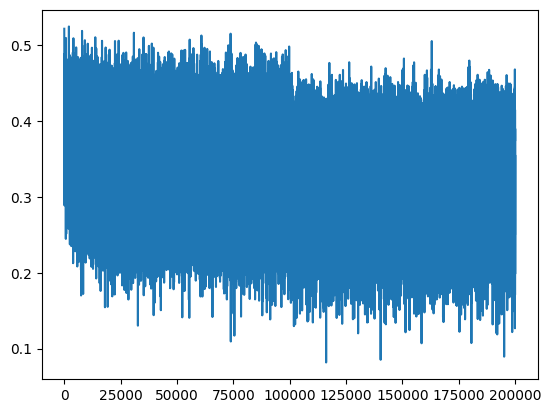

In [5]:
plt.plot(lossi)

In [6]:
@torch.no_grad()
def split_loss(split):
    x,y={
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb=C[x] # (N, block_size, n_embd)
    embcat=emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    h=torch.tanh(embcat @W1+b1) # (N, n_hidden)
    logits=h@W2+b2 #(N, vocab_size)
    loss=F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.069589138031006
val 2.1310746669769287


In [7]:
g=torch.Generator().manual_seed(2147483647+10)

for _ in range(20):
    out=[]
    context=[0]*block_size # initialize with all ...
    while True:
        # forward pass the neural net
        emb=C[torch.tensor([context])] # (1, block_size, n_embd)
        h=torch.tanh(emb.view(1,-1) @ W1+b1)
        logits=h@W2+b2
        probs=F.softmax(logits, dim=1)
        # sample from the distribution
        ix=torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context=context[1:]+[ix]
        out.append(ix)
        if ix==0:
            break
    print(''.join(itos[i] for i in out)) # decode the print and the generated word

mora.
mayah.
seel.
ndyn.
alerethruthadrie.
cadelyn.
elin.
shi.
jen.
eden.
est.
aarvelyzion.
kamin.
shub.
roshimies.
kin.
renlynn.
novana.
ubeen.
der.


# Acknowledgement

* https://www.youtube.com/watch?v=P6sfmUTpUmc&t=41s
* https://www.kaggle.com/code/aisuko/character-lm-without-framework